In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import os.path
import os

import folium
from scipy import stats
from shapely.geometry import Polygon, mapping
import json
import matplotlib.cm as cm



In [16]:
BTVpolice = pd.read_csv('BTVpolice.csv')

In [17]:
print('---------Call Type---------')
print(BTVpolice['call_type'].value_counts())
print('\n\n---------Call Street---------')
print(BTVpolice['Street'].value_counts())

---------Call Type---------
call_type
Suspicious Event                       5976
Foot Patrol                            5722
Welfare Check                          2424
Trespass                               2281
Assist - Public                        2226
                                       ... 
Runaway Apprehension                      1
Search                                    1
Embezzlement                              1
Contributing to Deliquency of Minor       1
Enabling Consumption by Minors            1
Name: count, Length: 128, dtype: int64


---------Call Street---------
Street
North Ave                 4572
Marketplace               3316
Airport Dr                2494
Church St                 2437
College St                1915
                          ... 
Lafountain St/Cedar St       1
I 89 Sb Mm 93.3              1
Browns Court Lot             1
Memorial Auditorium          1
S Prospect / Main St         1
Name: count, Length: 3237, dtype: int64


/var/folders/05/b_dps8k90m5d6w0ttvf7hzg40000gn/T/ipykernel_3241/1458817710.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('plasma', len(contour_levels))
/var/folders/05/b_dps8k90m5d6w0ttvf7hzg40000gn/T/ipykernel_3241/1458817710.py:26: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, level in enumerate(contours.collections):


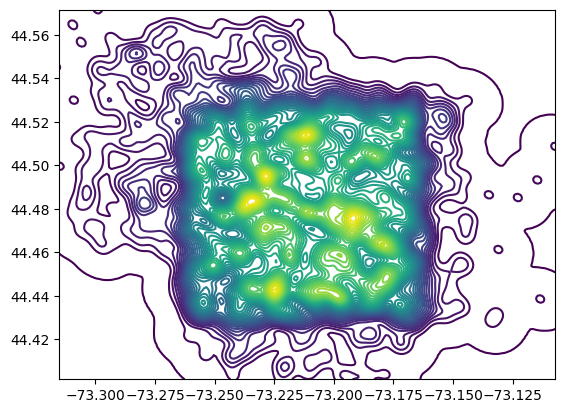

In [28]:


BTVpoliceP1 = BTVpolice[BTVpolice['priority'] == "Priority 1"]

BTVpoliceP1Filtered = BTVpoliceP1.dropna(subset=['Latitude', 'Longitude'])

x = BTVpoliceP1Filtered['Longitude'].values
y = BTVpoliceP1Filtered['Latitude'].values

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values, bw_method=0.1)
density = np.reshape(kernel(positions).T, xx.shape)

contour_levels = np.linspace(density.min() + 0.0001, density.max(), 40)  #change last number to add levels

features = []

colormap = cm.get_cmap('plasma', len(contour_levels))

fig, ax = plt.subplots()
contours = ax.contour(xx, yy, density, levels=contour_levels)

for i, level in enumerate(contours.collections):
    color = colormap(i / len(contour_levels))
    for contour_path in level.get_paths():
        for segment in contour_path.to_polygons():
            poly = Polygon(segment)
            if poly.is_valid:
                feature = {
                    "type": "Feature",
                    "geometry": mapping(poly),
                    "properties": {
                        "level": contour_levels[i],
                        "color": f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 0.4)' 
                    }
                }
                features.append(feature)

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

burlington_map = folium.Map(location=[44.4759, -73.2121], zoom_start=13)

folium.GeoJson(
    geojson_data,
    style_function=lambda feature: {
        "fillColor": feature["properties"]["color"],
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.1  #Decrease opacity to increase map visibility
    }
).add_to(burlington_map)

burlington_map
